In [20]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import cv
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import holidays
from xgboost import XGBRegressor
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from feature_engineering import FeatureEngineering
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [21]:
file_path = 'marketing_campaign_dataset.csv'

In [22]:
The dataset consists of marketing campaign data with the following columns:

1. **Campaign_Type**: The type of marketing campaign (e.g., Email, Influencer, Social Media, etc.).
2. **Target_Audience**: The target audience for the campaign (e.g., Men 18-24, Women 25-34, etc.).
3. **Duration**: The duration of the campaign in days.
4. **Channel_Used**: The channel used for the campaign (e.g., Google Ads, YouTube, Facebook, etc.).
5. **Conversion_Rate**: The conversion rate achieved by the campaign.
6. **Acquisition_Cost**: The cost of acquiring customers during the campaign.
7. **ROI**: The return on investment for the campaign.
8. **Clicks**: The number of clicks received during the campaign.
9. **Impressions**: The number of impressions generated by the campaign.
10. **Engagement_Score**: A score representing the engagement level of the campaign.
11. **Date**: The date of the campaign.

The dataset contains 200,000 rows and 15 columns, with a mix of numerical, categorical, and datetime data. It is used for analyzing and predicting the performance of marketing campaigns.

SyntaxError: invalid syntax (3070541077.py, line 1)

In [26]:
def clean_data(file_path):
    df = pd.read_csv(file_path)
    df = df.dropna()
    df = df.drop_duplicates()
    df = df.drop('Company', axis = 1)
    df = df.drop('Location', axis = 1)
    df = df.drop('Language', axis = 1)
    df = df.drop('Customer_Segment', axis = 1)
    df = df.drop('Campaign_ID', axis = 1)
    df['Duration'] = df['Duration'].str.replace(' days', '').astype(int)
    df['Acquisition_Cost'] = df['Acquisition_Cost'].astype(str).str.replace(r'[\$,]', '', regex=True).astype(float)
    df['Date'] = pd.to_datetime(df['Date'])

    return df

In [27]:
data = clean_data(file_path)
data.head()

,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Clicks,Impressions,Engagement_Score,Date
0,Email,Men 18-24,30,Google Ads,0.04,16174.0,6.29,506,1922,6,2021-01-01
1,Email,Women 35-44,60,Google Ads,0.12,11566.0,5.61,116,7523,7,2021-01-02
2,Influencer,Men 25-34,30,YouTube,0.07,10200.0,7.18,584,7698,1,2021-01-03
3,Display,All Ages,60,YouTube,0.11,12724.0,5.55,217,1820,7,2021-01-04
4,Email,Men 25-34,15,YouTube,0.05,16452.0,6.50,379,4201,3,2021-01-05


We also added some features:
1. **Day_Type**: Indicates whether the campaign occurred on a weekday or weekend using the holiday package.
2. **Click-Through_Rate**: The ratio of clicks to impressions.
3. **Cost_Per_Click**: The acquisition cost per click for the campaign.
4. **Is_Holiday**: Indicates whether the campaign date was a holiday (1 for holiday, 0 otherwise).

In [29]:
def add_weekdayweekend_to_date(data):
    df = data
    df['Date'] = pd.to_datetime(df['Date'])
    df["Day_Type"] = df["Date"].apply(lambda x: "Weekend" if x.weekday() >= 5 else "Weekday")
    return df

df = add_weekdayweekend_to_date(data)

In [30]:
def add_features(df):
        us_holidays_2021 = set(holidays.US(years=2021).keys())
        df['Click-Through_Rate'] = df['Clicks'] / df['Impressions']
        df['Cost_Per_Click'] = df['Acquisition_Cost'] / df['Clicks']
        df['Is_Holiday'] = df['Date'].isin(us_holidays_2021).astype(int)
        df = df.drop('Date', axis = 1)
        df = df.drop('Impressions', axis = 1)
        df = df.drop('Clicks', axis = 1)
        return df

df = add_features(df)

C:\Users\Edsel\AppData\Local\Temp\ipykernel_20744\1544967696.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['Is_Holiday'] = df['Date'].isin(us_holidays_2021).astype(int)


For this regression task, we would be using two models, Random Forest Regressor and XGBoost.

Random Forest Regressor (RFR) is an ensemble learning method used for regression tasks. It operates by constructing multiple decision trees during training and outputs the average of the predictions from all the trees. This approach helps to reduce overfitting and improves the model's generalization ability. The metric to use would be RMSE (Root Mean Squared Error) which represents how far apart the predicted values and the actual values are.

RFR is particularly useful when the dataset has complex interactions between features or when overfitting is a concern. It is a reliable choice for regression tasks in various domains, such as marketing, finance, and healthcare.

In [31]:

# Define features (X) and target (y)'
X = df.drop('ROI', axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['ROI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train)

        Duration  Conversion_Rate  Acquisition_Cost  Engagement_Score  \
153248        15             0.05            8375.0                 5   
67802         30             0.03           19992.0                 4   
148889        15             0.05           15241.0                 9   
103093        60             0.15           19578.0                 5   
104681        45             0.05           11850.0                 1   
...          ...              ...               ...               ...   
119879        45             0.07            5100.0                 2   
103694        60             0.09           11370.0                 4   
131932        30             0.08            8602.0                 2   
146867        15             0.06           18509.0                 8   
121958        60             0.08           15793.0                 6   

        Click-Through_Rate  Cost_Per_Click  Is_Holiday  Campaign_Type_Email  \
153248            0.149697        8.696781  

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train and evaluate model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Display results
results = {"RMSE": rmse}
results_df = pd.DataFrame([results])
print(results_df)

       RMSE
0  1.757751


A base model of Random Forest Regressor produced an RMSE of 1.757751, and took around 3 minutes 40 seconds to complete.

We will be moving on to an XGBoost model.

In [ ]:
# Initialize the XGBoost Regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

# Display results
results_xgb = {"RMSE": rmse_xgb}
results_xgb_df = pd.DataFrame([results_xgb])
print(results_xgb_df)

       RMSE
0  1.748318


A base model of XGBoost produced an RMSE of 1.748318 and took around 0.5s to complete.

<Figure size 1000x800 with 0 Axes>

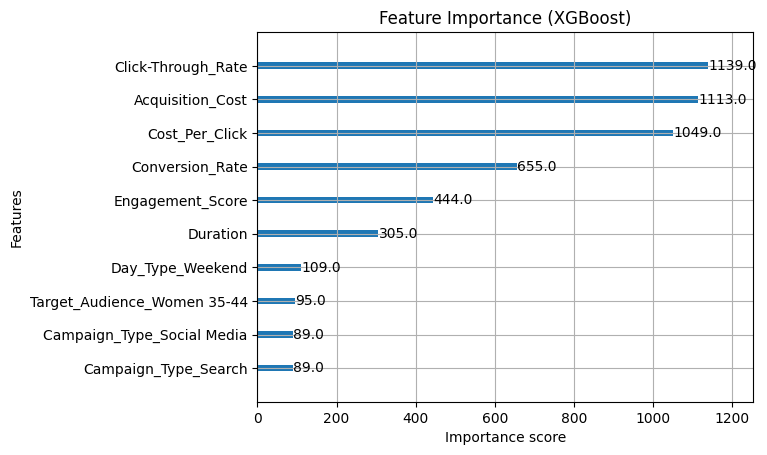

In [ ]:
from xgboost import plot_importance

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (XGBoost)')
plt.show()

Click Through Rate, Cost per click seems to be much more important in the XGBoost model.


In conclusion, just by comparing the base models, I am more inclined to pick the XGBoost models as not only does it perform better, it is much more efficient in picking up larger datasets and multiple categorical and numerical features. The XGBoost model also allowed me to plot importance between the features, which can provide much more insight as to what to focus on during a bank marketing campaign. A further revision of this is to explore hyperparameter tuning, as to improve upon this XGBoost model.